**FOR3004 Tutorial 7: Integer Programming for Spatial Planning in LINGO & Google OR-Tools**

Tutorial Problem: The Forest Management Unit (FMU) has asked you to design a timber harvesting program over 3 time steps. 

They have the following instructions for you: 

(1) They want a spatially-explicit solution. The FMU area is split into 9 equal parts (“stands”) on a regular grid.

(2) If a stand is harvested in a time step, the stands that are Rooks-case adjacent to it cannot be harvested. 

(3) The stand cannot be harvested more than once but it must be harvested at least once before the end of the time steps. 

(4) They want to maximize the volume harvested over the time steps. 


(1) We need to install and import the packages we will be using. 

In [14]:
#Install the packages we need, including Google OR-Tools 
%%capture
!pip install ortools
!pip install pandas
!pip install numpy
!pip install matplotlib

In [15]:
#Here we are importing the packages we need. 

import pandas as pd
from ortools.linear_solver import pywraplp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

(2) We need to set up our "knowns" / data about our FMU. 

In [16]:
#Because we are programming in space, we need to use array format. We define an
#array using np.array. The shape of the array is defined by brackets and commas.
stand_ids = np.array([[1,2,3],
                      [4,5,6],
                      [7,8,9]])

#Starting volumes m3 / ha
stand_volumes_t1 = np.array([[150,120,110],
                      [100,180,170],
                      [150,145,120]]) 
#Stand volume (hypothetical) if not havested in T1 
stand_volumes_t2 = np.array([[160,140,120],
                      [115,190,180],
                      [155,160,130]]) 
#Stand volume (hypothetical) if not havested in T1 or T2 
stand_volumes_t3 = np.array([[180,170,130],
                      [130,200,190],
                      [160,175,140]]) 

Let's visualize what this looks like in space, so we have a better idea of what is going on. 

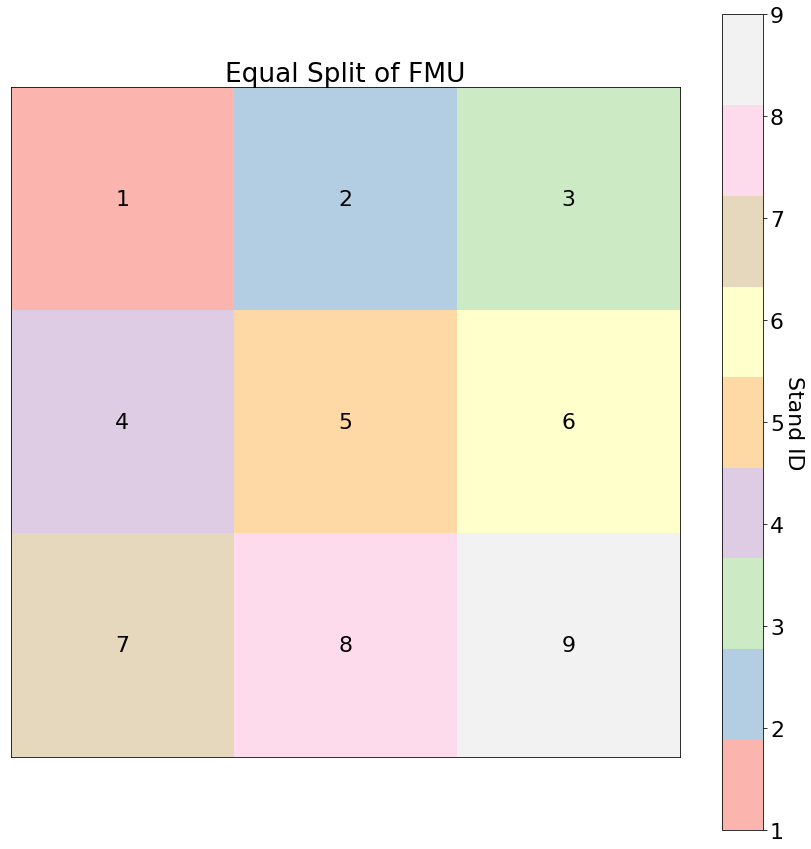

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
matplotlib.rcParams.update({'font.size': 22})
gk = plt.imshow(stand_ids,vmin=np.nanmin(stand_ids),\
                vmax=np.nanmax(stand_ids),cmap='Pastel1')
c = fig.colorbar(gk)
c.set_label('Stand ID', rotation=270,labelpad=20)
ax.set_title('Equal Split of FMU')
for (j,i),label in np.ndenumerate(stand_ids):
    ax.text(i,j,label,ha='center',va='center')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

(3) We need to define some "helper" functions (blocks of code to complete tasks for us). Specifically, a helper function to calculate the neighbours for us. You can also find that information in the tutorial slides. 

In [18]:
def calc_neighborhood(array):
    '''Calculate and return the neighbors of each cell in the array. From: 
    https://github.com/MaxRudometkin/2d_array_neighbours/blob/master/array_neighbours.py 
    '''
    neighbors = {} 

    for i in range(len(array)):
        for j, value in enumerate(array[i]):

            if i == 0 or i == len(array) - 1 or j == 0 or j == len(array[i])- 1:
                nlist = []
                if i != 0:
                    nlist.append(array[i - 1][j])  
                if j != len(array[i]) - 1:
                    nlist.append(array[i][j + 1])  
                if i != len(array) - 1:
                    nlist.append(array[i + 1][j])  
                if j != 0:
                    nlist.append(array[i][j - 1])  

            else:
                nlist = [
                    array[i - 1][j], 
                    array[i][j + 1],  
                    array[i + 1][j],  
                    array[i][j - 1]   
                ]

            neighbors[value]=  nlist

    return neighbors

(4) We need to create a dataframe (a table) with our known information - this is the one that you are seeing / have seen in the slides! 

In [19]:
# Get a list of the stand id's. This looks complicated, but that's all it's
#getting us. 
stack_arrays = list(np.hstack([stand_volumes_t1.flatten(),\
                               stand_volumes_t2.flatten(),\
                               stand_volumes_t3.flatten()]).flatten())

#Initialize an empty dataframe. 
information = pd.DataFrame() 

#Get the time step information - also looks complicated but this is just creating
#a list of numbers that will go in as a column in our table. 
ts1 = np.ones(stand_ids.shape)
ts2 = np.ones(stand_ids.shape)*2
ts3 = np.ones(stand_ids.shape)*3

time_step = list(np.hstack([ts1.flatten(),ts2.flatten(),ts3.flatten()]).flatten())

#Put relevant information into the dataframe / table. 
information['stand_id'] = list(np.array(list(stand_ids)*3).flatten())
information['vol'] = stack_arrays
information['time_step'] = time_step

neighborhoods = calc_neighborhood(stand_ids)
n_list = []
for key in list(information['stand_id']): #Loop through the stand ids
    n = neighborhoods[key] #Get the neighborhood from the helper function
    n_list.append(n) #Send it to an empty list, which we will send to the dataframe
  
information['neighbors'] = n_list

print(information)

    stand_id  vol  time_step     neighbors
0          1  150        1.0        [2, 4]
1          2  120        1.0     [3, 5, 1]
2          3  110        1.0        [6, 2]
3          4  100        1.0     [1, 5, 7]
4          5  180        1.0  [2, 6, 8, 4]
5          6  170        1.0     [3, 9, 5]
6          7  150        1.0        [4, 8]
7          8  145        1.0     [5, 9, 7]
8          9  120        1.0        [6, 8]
9          1  160        2.0        [2, 4]
10         2  140        2.0     [3, 5, 1]
11         3  120        2.0        [6, 2]
12         4  115        2.0     [1, 5, 7]
13         5  190        2.0  [2, 6, 8, 4]
14         6  180        2.0     [3, 9, 5]
15         7  155        2.0        [4, 8]
16         8  160        2.0     [5, 9, 7]
17         9  130        2.0        [6, 8]
18         1  180        3.0        [2, 4]
19         2  170        3.0     [3, 5, 1]
20         3  130        3.0        [6, 2]
21         4  130        3.0     [1, 5, 7]
22         

(5) We need to initialize our integer programming problem using Google OR-Tools.

In [20]:
#Choose the type of solver we want. This is SCIP, read more here: 
#https://www.scipopt.org/

solver = pywraplp.Solver.CreateSolver('SCIP')

# Create a list of the variables (the unknowns)
var_list = ['x_11','x_21','x_31','x_41','x_51','x_61','x_71','x_81','x_91','x_12'\
            ,'x_22','x_32','x_42',\
            'x_52','x_62','x_72','x_82','x_92','x_13','x_23','x_33','x_43','x_53',\
            'x_63','x_73','x_83',\
            'x_93']

information['var_name'] = var_list[:27] #Add a column in our table for 
                                        #variable name 

# Create a dictionary (a way of storing data) containing the OR-Tools object for
#each of our variables (confusing... just how computers work)
var_collect = {}

for i in range(0, len(information)): 
    # solver.IntVar(0.0, 1, var_list[i]) --> tell computer that the variable can
    # only be 1 or 0. 
    var_collect[var_list[i]] = solver.IntVar(0.0, 1, var_list[i]) 
            
print(var_collect) #Print this dictionary so we can see it. 

locals().update(var_collect) #Turn the variables from 
                             # strings (text) to actual variables 

print('Number of variables =', solver.NumVariables()) #Print number of variables

{'x_11': x_11, 'x_21': x_21, 'x_31': x_31, 'x_41': x_41, 'x_51': x_51, 'x_61': x_61, 'x_71': x_71, 'x_81': x_81, 'x_91': x_91, 'x_12': x_12, 'x_22': x_22, 'x_32': x_32, 'x_42': x_42, 'x_52': x_52, 'x_62': x_62, 'x_72': x_72, 'x_82': x_82, 'x_92': x_92, 'x_13': x_13, 'x_23': x_23, 'x_33': x_33, 'x_43': x_43, 'x_53': x_53, 'x_63': x_63, 'x_73': x_73, 'x_83': x_83, 'x_93': x_93}
Number of variables = 27


(6) Our next step is to define the constraints. Remember, these are: (a) the adjacency constraints and (b) the harvest time step constraints. 

In [21]:
# We need to create an index column in our original table. 
information['lookup_index'] = range(0, len(information))

#List of variables, note the lack of '' because we have applied locals().update(var_collect)
vars = [x_11,x_21,x_31,x_41,x_51,x_61,x_71,x_81,x_91,x_12\
            ,x_22,x_32,x_42,\
            x_52,x_62,x_72,x_82,x_92,x_13,x_23,x_33,x_43,x_53,\
            x_63,x_73,x_83,\
            x_93] 

# time step 1 
tracker = [] #Track the constraints done so far
time1 = information[information['time_step'] == 1.0] #Filter table for Time step 1
for id in time1['stand_id']: #Loop through stand ids
  df = time1[time1['stand_id'] == id] #Get record / row for stand id 
  var = vars[id-1] #Get corresponding variable name for stand id. 
  ne = df['neighbors'] #Obtain neighbours of stand. 
  constraint = [vars[i-1] for i in list(ne)[0]] #Constraint = neighbours. 
  for c in constraint: #Loop through constraints / neighbours. 
    #We don't want two of the same constraints, so make sure we haven't 
    #already created the constraint in the opposite order. 
    if [str(var),str(c)] not in tracker and [str(c),str(var)] not in tracker:
      #Add the constraint to the Google OR-Tools solver.  
      solver.Add(var + c <= 1)
      #Append the constraint information to the tracker so we don't re-append it. 
      tracker.append([str(var),str(c)])

# time step 2
time1 = information[information['time_step'] == 2.0]
for id in time1['stand_id']: 
  df = time1[time1['stand_id'] == id]
  var = vars[id+8] #Plus 8 because of index in original table. 
  ne = df['neighbors']
  constraint = [vars[i+8] for i in list(ne)[0]]
  for c in constraint: 
    if [str(var),str(c)] not in tracker and [str(c),str(var)] not in tracker: 
      solver.Add(var + c <= 1)
      tracker.append([str(var),str(c)])

# time step 3 
time1 = information[information['time_step'] == 3.0]
time1 = time1[time1['stand_id'] <= 26]
count = 0 
for id in time1['stand_id']: 
  df = time1[time1['stand_id'] == id]
  var = vars[id+17]
  ne = df['neighbors']
  constraint = [vars[i+17] for i in list(ne)[0]]
  for c in constraint: 
    if [str(var),str(c)] not in tracker and [str(c),str(var)] not in tracker: 
      solver.Add(var + c <= 1)
      tracker.append([str(var),str(c)])

#Cannot harvest except in one of the time steps 
for sid in list(set(information['stand_id'])): #Loop through stand ids. 
    time1 = information[information['stand_id'] == sid] #Get all records with
                                                        #that stand id. 
    track_cvar = [] 
    for id in time1['lookup_index']:
      c_var = vars[id]
      track_cvar.append(c_var)
    solver.Add(sum(track_cvar) == 1) #Sum of those 3 stands must be 1. 
#Print number of constraints. 
print('Number of constraints =', solver.NumConstraints()) 

Number of constraints = 45


(7) Now we need to define the objective function. 

In [22]:
#Tell computer that each component of the objective function is volume * variable
obj_collect = [i*j for i, j in zip(vars,list(information['vol']))]
#Tell the computer to maximize the sum of these volume*variable pairs 
solver.Maximize(sum(obj_collect))

(8) Solve using Google OR-Tools. 

In [23]:
#Solve 
status = solver.Solve()

#Get information from solver 
decision = [] 
if status == pywraplp.Solver.OPTIMAL:
    
    print('Objective value =', solver.Objective().Value())
    for var in vars: 
      #Append to decision list the solution for the specific variable. 
      decision.append(abs(var.solution_value()))
else:
    print('The problem does not have an optimal solution.')

if len(decision) > 0: 
  #Append a row to the original table IF there is an optimal solution
  information['cut'] = decision 

#Here's our table. 'cut' tells us whether to harvest or not. 
print(information[['stand_id','time_step','var_name','cut']])

Objective value = 1420.0
    stand_id  time_step var_name  cut
0          1        1.0     x_11  0.0
1          2        1.0     x_21  0.0
2          3        1.0     x_31  0.0
3          4        1.0     x_41  0.0
4          5        1.0     x_51  0.0
5          6        1.0     x_61  0.0
6          7        1.0     x_71  0.0
7          8        1.0     x_81  0.0
8          9        1.0     x_91  0.0
9          1        2.0     x_12  1.0
10         2        2.0     x_22  0.0
11         3        2.0     x_32  1.0
12         4        2.0     x_42  0.0
13         5        2.0     x_52  1.0
14         6        2.0     x_62  0.0
15         7        2.0     x_72  1.0
16         8        2.0     x_82  0.0
17         9        2.0     x_92  1.0
18         1        3.0     x_13  0.0
19         2        3.0     x_23  1.0
20         3        3.0     x_33  0.0
21         4        3.0     x_43  1.0
22         5        3.0     x_53  0.0
23         6        3.0     x_63  1.0
24         7        3.0  

The solution is the same as we got from LINGO! Let's visualize it. 

[[2. 3. 2.]
 [3. 2. 3.]
 [2. 3. 2.]]


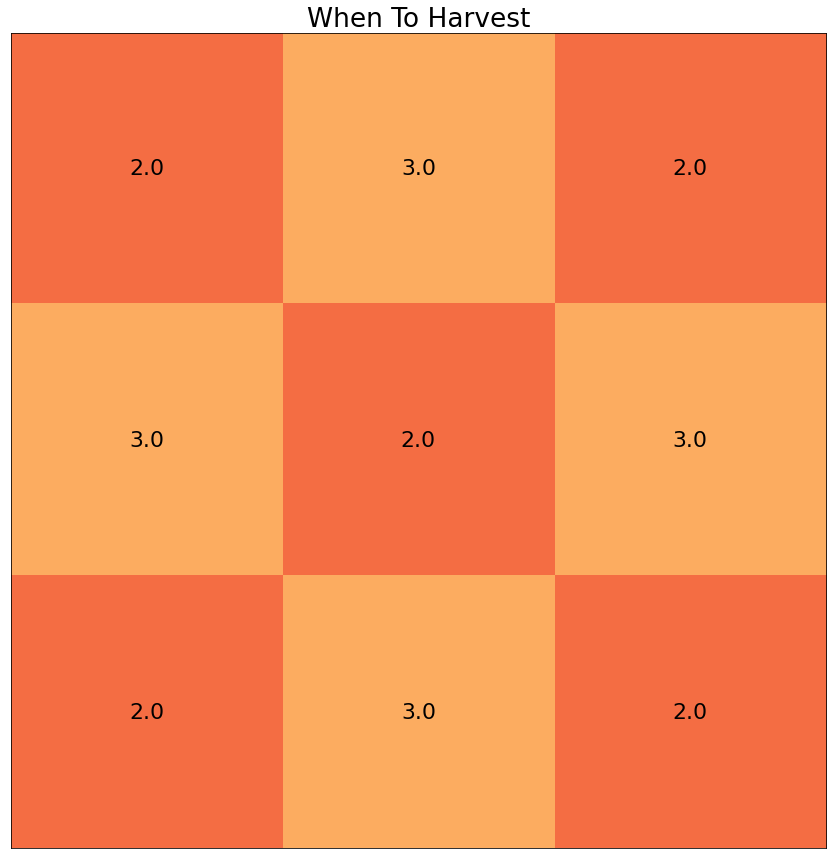

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))
matplotlib.rcParams.update({'font.size': 22})
new_array = np.zeros(stand_ids.shape)
new_array[0][0] = 2
new_array[0][1] = 3
new_array[0][2] = 2
new_array[1][0] = 3
new_array[1][1] = 2
new_array[1][2] = 3
new_array[2][0] = 2
new_array[2][1] = 3
new_array[2][2] = 2
print(new_array)
gk = plt.imshow(new_array,vmin=0,\
                vmax=10,cmap='RdYlBu')
ax.set_title('When To Harvest')
for (j,i),label in np.ndenumerate(new_array):
    ax.text(i,j,label,ha='center',va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

(9) Tutorial Problem: In groups, use LINGO or Google OR-Tools to modify the result so that it accounts for an additional constraint from the FMU: 
(1) At least one stand must be harvested in each time period.
 Hint: This means that the all of the variables for each time step must add up to be >= 1.

In [25]:
#Comment out following line to see answer!
%%capture 
#Must harvest one stand in each time step 
for ts in list(set(information['time_step'])): #Loop through time steps. 
    time1 = information[information['time_step'] == ts] #Get all records with
                                                        #that time step. 
    track_ts = [] 
    for id in time1['lookup_index']:
      ts_var = vars[id]
      track_ts.append(ts_var)
    solver.Add(sum(track_ts) >= 1) #Sum of those variables in the time step
                                   # must be > = 1. 

#Solve 
status = solver.Solve()

#Get information from solver 
decision = [] 
if status == pywraplp.Solver.OPTIMAL:
    
    print('Objective value =', solver.Objective().Value())
    for var in vars: 
      #Append to decision list the solution for the specific variable. 
      decision.append(abs(var.solution_value()))
else:
    print('The problem does not have an optimal solution.')

if len(decision) > 0: 
  #Append a row to the original table IF there is an optimal solution
  information['cut'] = decision 

#Here's our table. 'cut' tells us whether to harvest or not. 
print(information[['stand_id','time_step','var_name','cut']])

What does the new solution look like? 

[[2. 3. 2.]
 [3. 2. 3.]
 [1. 3. 2.]]


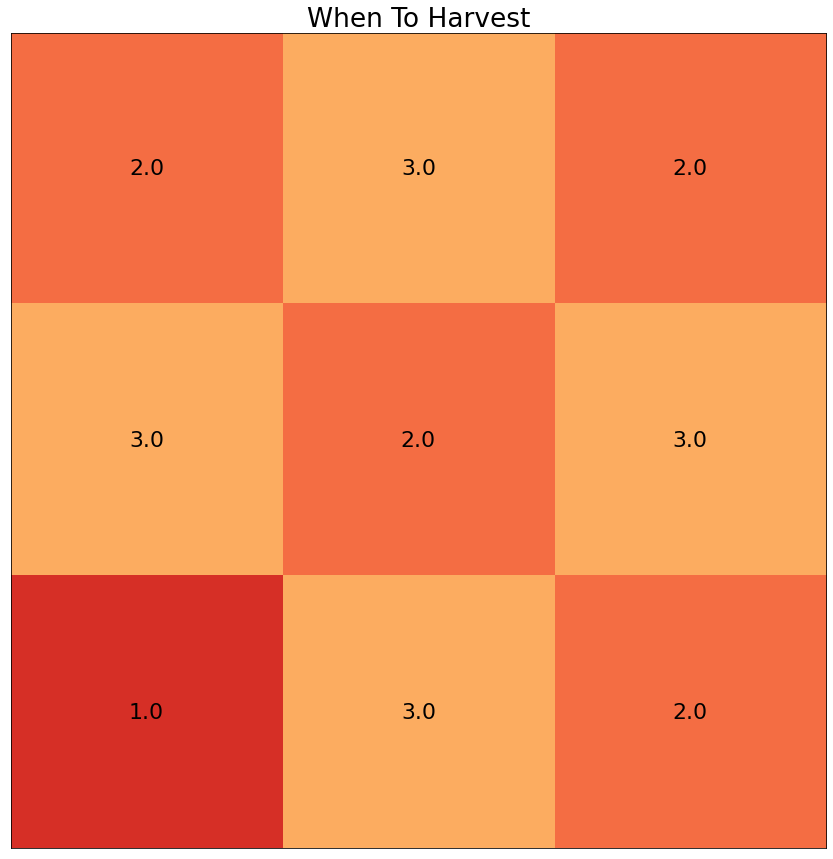

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
matplotlib.rcParams.update({'font.size': 22})
new_array = np.zeros(stand_ids.shape)
new_array[0][0] = 2
new_array[0][1] = 3
new_array[0][2] = 2
new_array[1][0] = 3
new_array[1][1] = 2
new_array[1][2] = 3
new_array[2][0] = 1
new_array[2][1] = 3
new_array[2][2] = 2
print(new_array)
gk = plt.imshow(new_array,vmin=0,\
                vmax=10,cmap='RdYlBu')
ax.set_title('When To Harvest')
for (j,i),label in np.ndenumerate(new_array):
    ax.text(i,j,label,ha='center',va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()